# Brains, weighted distributions, and KL-divergence

This notebook presents the numerical second-order approximation of the KL-divergence for weighted distributions. For a full discussion see [**my post on Medium.**](https://medium.com/the-quantastic-journal/the-kullback-leibler-divergence-for-weighted-density-functions-f6672874d519)

My goal was to explore ways to characterize any system that collects data and attempts to create a predictive model of reality through an imperfect and potentially biased process. For example, thinking about brains, the process might be biased and imperfect due to sensory limitations. This is true both for biological brains and artificial systems. 

Here, $\textit{biased}$ means that the brain data collection process does not represent the real distribution of the observable $\textit{x}$, for example, oversampling some ranges of values for $\textit{x}$, and downsampling others.

The brain would then attempt to reconstruct the real distribution and minimize the discrepancy between reality and the prediction. This is an idea similar to the brain [Free Energy Principle](https://www.fil.ion.ucl.ac.uk/~karl/A%20free%20energy%20principle%20for%20the%20brain.pdf), which also relies on the KL concept. 

If such an imperfect process could be modeled as weighted distribution acting on the real distribution $f(x,\theta)$, with $\theta$ being the parameter, $w$ the weight, and $N$ a normalization factor:

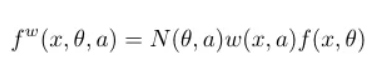

Then it is possible to show that the KL-divergence between the observed and real distribution splits into a statistical Fisher term $\mathcal{I_0}$, and additional terms that are there only because of the observational bias:

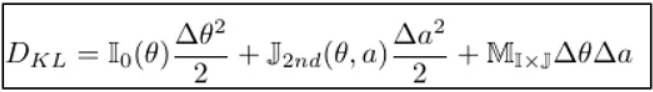

This notebook shows the explicit calculation of the statistical (Fisher) and biased-dependent terms.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import rel_entr
import seaborn as sn

### Unbiased distribution

Let's assume that the ubiased distribution is a normal $f(x,\theta)$. 

In [2]:
def normal_pdf(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Define values of x, mu, andsigma
x_values = np.linspace(-6, 6, 250)     # Values of x
mu_values = np.linspace(-5, 5, 231)    # Values of mu (or theta to be consistent with the formulas in the notebook)
sigma = 1                              # Constant standard deviation

# Create a meshgrid of x and mu values
x_mesh, mu_mesh = np.meshgrid(x_values, mu_values, indexing='ij')

# Compute the normal distribution for each combination of x and mu
pdf_matrix = normal_pdf(x_mesh, mu_mesh, sigma)


### Introducing bias

We now introduce a weight of the form

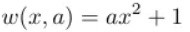

with $a$ a parameter that controls the bias. Note that $a=0$ gives the unbiased distribution.

In [3]:
def modifying_function(x, a):
    return  a*x**2 + 1.
a_values = np.linspace(- .5, .5, 121)    # Values of a

# Create a meshgrid of x and a values
x_mesh, a_mesh = np.meshgrid(x_values, a_values, indexing='ij')

# Compute the normal distribution for each combination of x and mu
Warray_unnorm = modifying_function(x_mesh, a_mesh)
xplot = x_mesh[:,0]

##### Let's look at how this bias affects the real distribution, by selecting any value $a\ne0$

In [4]:
Warray_unnorm_res = Warray_unnorm[:,:,np.newaxis]
pdf_matrix_res = pdf_matrix[:,np.newaxis,:]

pdf_mod_unnorm = Warray_unnorm_res*pdf_matrix_res

norma_int = np.trapz(pdf_mod_unnorm,x_values,axis=0)
# # normalization factor N in f_obs= f*N*W
norma = 1./norma_int
pdf_mod = pdf_mod_unnorm*norma

Warray = Warray_unnorm

In [5]:
central_ind = 60   ## index of a = 0, w=1, no bias
dev = 65           ## a generic value a!=0, sufficiently close to a = 0, as we are Taylor expanding next


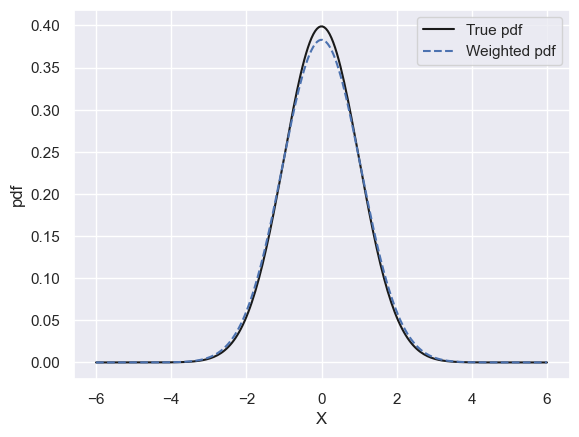

In [6]:
sn.set_theme()
# sn.despine(left=True, bottom=True, right=True, top=True)

plt.plot(xplot,pdf_mod[:,a_values==a_values[central_ind],mu_values==mu_values[115]],label='True pdf',color='k',linestyle='-')
plt.plot(xplot,pdf_mod[:,a_values==a_values[dev],mu_values==mu_values[115]],linestyle='--',color='b',label='Weighted pdf')
plt.xlabel('X')
plt.ylabel('pdf')
plt.legend()


##### The weight downsamples the central values of x, and oversamples the tails of the distribution 

### Calculate Analytic KL

This will be useful later

In [7]:
# define masks
mask_a = a_values==a_values[central_ind]
mask_mu = mu_values == 0


The standard KL calculation between biased and unbiased distribution

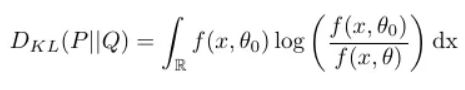

In [8]:
a_kl = rel_entr(pdf_matrix[:,mu_values==0],pdf_mod[:,a_values==a_values[dev],mu_values==mu_values[116]])
a_kl    = a_kl.reshape(250,)
full_kl = np.trapz(a_kl,x_mesh[:,0])
full_kl

0.0024802720297223135

##### The value above is the expected total divergence for this particular value of a

### Taylor expansion

I will now Taylor expand the KL divergence up to the second order and in a neigborhood of the unbiased distribution with the correct parameters ($a=0$ and $\theta=0$). Basically this:

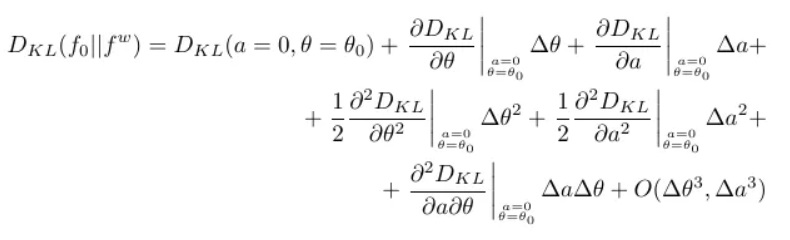

There will be what I call Fisher terms, that do not depend on the bias, and bias dependent terms, that I call $\mathcal{J}-$terms. All the first-order terms have to be null, because they involve derivatives of integrals of normalized distributions, which are derivatives of a constant. I will verify that these terms are null numerically.

##### Fisher Term First Order (expect ~0)

If you expand the above derivatives you will find that this term is:

$$f_0 N_0 W_0\left[-\frac{1}{N}\frac{d N}{d\theta} -\frac{1}{f}\frac{d f}{d\theta}\right]$$

Let's calculate it:

In [9]:
norma_grad_mu  = np.gradient(norma, mu_values, axis = 1, edge_order=2)

In [10]:
pdf_grad_mu  = np.gradient(pdf_mod,mu_values, axis = 2, edge_order=2)


In [11]:
pdf0_grad_mu  = np.gradient(pdf_matrix,mu_values, axis = 1, edge_order=2)


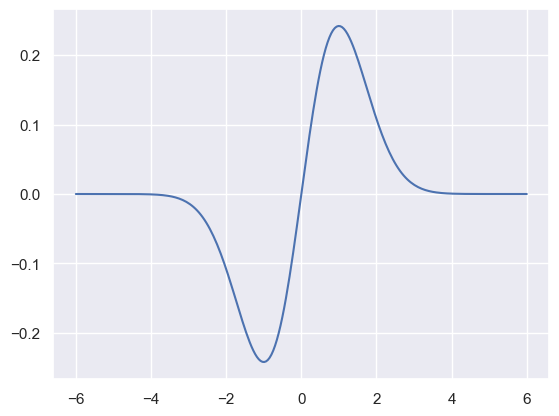

In [12]:
plt.plot(xplot,pdf0_grad_mu[:,mask_mu])


##### the pdf dependent term of the integrand of the Fisher first order term is visibly symmetric, which is promising, as the integral will be small.

In [13]:
# integral of derivative of pdf, will be numerically small
np.trapz(pdf_grad_mu[:,mask_a,mask_mu].reshape(250,),xplot)

9.936496070395151e-15

Now let's calculate the full Fisher first order term
$$f_0 N_0 W_0\left[-\frac{1}{N}\frac{d N}{d\theta} -\frac{1}{f}\frac{d f}{d\theta}\right]$$

In [14]:
fisher_first = Warray[:,mask_a]*norma[mask_a,mask_mu]*pdf_matrix[:,mask_mu]*\
(-norma_grad_mu[mask_a,mask_mu]/norma[mask_a,mask_mu] - \
 pdf0_grad_mu[:,mask_mu]/pdf_matrix[:,mask_mu])


In [15]:
fisher_first_term = np.trapz(fisher_first.reshape(250,),xplot)*mu_values[116]
fisher_first_term

-4.609839080508822e-16

##### This is small enough, if you compare with what we expect the KL to be from the analytical calculation above ($DKL\simeq 2.5e-4$)

### Jterm First Order (expect ~0)

##### This is the first order $\mathcal{J}-$term introduced by the bias. We expect it to be null.

$$f_0 N_0 W_0 \left[-\frac{1}{W}\frac{d W}{da} -\frac{1}{N}\frac{d N}{da}\right]$$

In [16]:
W_grad_a = np.gradient(Warray,a_values, axis=1, edge_order=2)
norma_grad_a = np.gradient(norma[:,mu_values==0],a_values,axis=0, edge_order=2)

jterm1_w = \
W_grad_a[:,a_values==a_values[central_ind]]*pdf_matrix[:,mu_values== 0]*norma[a_values==a_values[central_ind],mu_values==0]*Warray[:,mask_a]/Warray[:,mask_a]
jterm1_n = \
norma_grad_a[a_values==a_values[central_ind]]*pdf_matrix[:,mu_values==0]*Warray[:,a_values==a_values[central_ind]]*Warray[:,mask_a]/norma[mask_a,mask_mu]

jterm1_w =-jterm1_w
jterm1_n =-jterm1_n

jterm1_w_int = np.trapz(jterm1_w.reshape(250,),x_mesh[:,0])
jterm1_n_int = np.trapz(jterm1_n.reshape(250,),x_mesh[:,0])


In [17]:
### numerical version
jterm_first_term = (jterm1_n_int + jterm1_w_int)*(a_values[dev]-a_values[central_ind])
jterm_first_term

2.8936360230250934e-06

##### Two orders of magnitude smaller than the KL, so probably ok, although might be refined

### Second order terms

This is were things become interesting because these terms are not null

##### Fisher Second Order

$$f_0 N_0 W_0\left[\frac{1}{N^2}\left(\frac{d N}{d\theta}\right)^2 -\frac{1}{N}\frac{d^2 N}{d\theta^2} + \frac{1}{f^2}\left(\frac{d f}{d\theta}\right)^2 -\frac{1}{f}\frac{d^2 f}{d\theta^2}\right]$$

In [18]:
# This is the calculation of the terms in the formula above. Nothing fancy, just derivatives
pdf0_grad_mu2 = np.gradient(pdf0_grad_mu,mu_values, axis = 1, edge_order=2)
norma_grad_mu2  = np.gradient(norma_grad_mu, mu_values, axis = 1, edge_order=2)

fisher_info = (pdf0_grad_mu[:,mask_mu])**2./pdf_matrix[:,mask_mu]**2.
fisher_info_2 = pdf0_grad_mu2[:,mask_mu]/pdf_matrix[:,mask_mu]

norma_info = (norma_grad_mu[mask_a,mu_values==0])**2./norma[mask_a,mu_values==0]**2.
norma_info_2 = norma_grad_mu2[mask_a,mu_values==0]/norma[mask_a,mu_values==0]

fisher_integrand = (fisher_info - fisher_info_2)*pdf_matrix[:,mu_values==0]*Warray[:,mask_a]*norma[mask_a,mask_mu]
norma_integrand = (norma_info - norma_info_2)
norma_integrand_x = norma_integrand[np.newaxis]*pdf_matrix[:,mu_values==0]*Warray[:,mask_a]*norma[mask_a,mask_mu]

##### Finally get the second order, Fisher term

In [19]:
fisher_term_2 = np.trapz(fisher_integrand.reshape(250,),xplot)*(mu_values[116])**2./2\
+np.trapz(norma_integrand_x.reshape(250,),xplot)*(mu_values[116])**2./2

In [20]:
fisher_term_2

0.000945180076108933

### Jterm Second Order

$$f_0 N_0 W_0\left[\frac{1}{N^2}\left(\frac{d N}{d a}\right)^2 -\frac{1}{N}\frac{d^2 N}{da^2} + \frac{1}{W^2}\left(\frac{d W}{da}\right)^2 -\frac{1}{W}\frac{d^2 W}{da^2}\right]$$

Again some derivatives to calculate, nothing complex:

In [21]:
Warray_grad_a = np.gradient(Warray, a_values, axis=1, edge_order = 2)
Warray_grad_a2 = np.gradient(Warray_grad_a, a_values, axis=1, edge_order = 2)

In [24]:
pdf_grad_a  = np.gradient(pdf_mod[:,:,mu_values==0],a_values, axis = 1, edge_order=2)
pdf_grad_a2    = np.gradient(pdf_grad_a, a_values, axis = 1, edge_order=2)
norma_grad_a2  = np.gradient(norma_grad_a, a_values, axis = 0, edge_order=2)


In [25]:
W_term = (Warray_grad_a[:,mask_a])**2./Warray[:,mask_a]**2.
W_term_2 = Warray_grad_a2[:,mask_a]/Warray[:,mask_a]

norma_term = (norma_grad_a[mask_a,0])**2./norma[mask_a,mu_values==0]**2.
norma_term_2 = norma_grad_a2[mask_a,0]/norma[mask_a,mu_values==0]


In [26]:
W_term_integrand = (W_term - W_term_2)*pdf_matrix[:,mask_mu]*Warray[:,mask_a]*norma[mask_a,mask_mu]
norma_term_integrand = (norma_term - norma_term_2)
norma_term_integrand_x = norma_term_integrand[np.newaxis,:]*pdf_matrix[:,mask_mu]*Warray[:,mask_a]*norma[mask_a,mask_mu]

In [27]:
jterm_2 = np.trapz(W_term_integrand.reshape(250,)+\
         norma_term_integrand_x.reshape(250,),xplot)*(a_values[dev]-a_values[central_ind])**2./2

In [28]:
jterm_2

0.0017357469449609663

### Cross-Term

The term that depends on the cross derivative wrt to $\theta$ and $a$

$$f_0 W_0 N_0\left[\frac{dN}{d\theta}\frac{dN}{da}\frac{1}{N^2}-\frac{d^2N}{d\theta da}\frac{1}{N}\right]$$

In [29]:
nn_a = np.gradient(norma,a_values,axis=0, edge_order=2)
nn_a_mu = np.gradient(nn_a,mu_values,axis=1, edge_order=2)
nn_mu = np.gradient(norma,mu_values,axis=1, edge_order=2)
nn_mu_a = np.gradient(nn_mu,a_values,axis=0, edge_order=2)


##### sanity check - cross derivatives are symmetric


In [30]:
nn_a_mu[mask_a,mask_mu],nn_mu_a[mask_a,mask_mu]

(array([-1.55253588e-12]), array([-1.49213975e-12]))

In [31]:
nn_a[mask_a,mask_mu],nn_mu[mask_a,mask_mu]

(array([-1.00006938]), array([1.0658141e-14]))

In [32]:
cross_term_1 = pdf_matrix[:,mask_mu]*norma_grad_mu[mask_a,mask_mu]*norma_grad_a[mask_a,]\
*Warray[:,mask_a]*norma[mask_a,mask_mu]/norma[mask_a,mask_mu]**2.
cross_term_2 = nn_a_mu[mask_a,mask_mu]*pdf_matrix[:,mask_mu]*Warray[:,mask_a]*norma[mask_a,mask_mu]/norma[mask_a,mask_mu]

In [33]:
cross_term = cross_term_1 - cross_term_2

In [34]:
kl_cross_term = np.trapz(cross_term.reshape(250,),xplot)*(mu_values[116])*(a_values[dev]-a_values[central_ind])

In [35]:
kl_cross_term

2.7932554241257713e-15

##### turns out this is negligible

# Total numerical KL divergence vs full analytical calculation

In [36]:
jterm_2 + fisher_term_2 + kl_cross_term + jterm_first_term + fisher_first_term,full_kl

(0.0026838206570952566, 0.0024802720297223135)

#### these valuse are close enough for a second order approximation

# Integrands Comparison

Let's put all the terms in a figure. These are the integrands terms. The red dots is their sum, and you can see how it matches the analytical expectation.

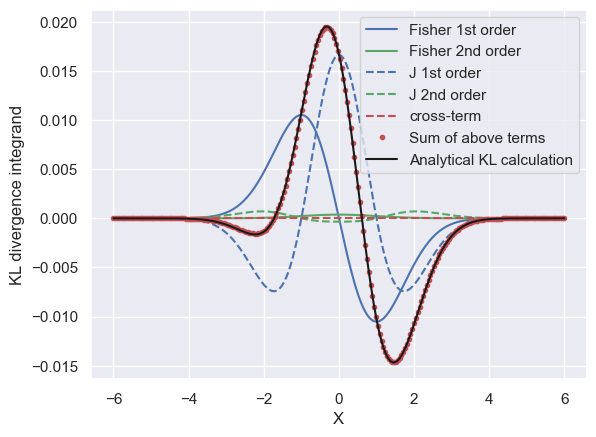

In [48]:
fisher_first_term_plot = fisher_first.reshape(250,)*mu_values[116]
jterm_first_plot = (jterm1_w + jterm1_n)*(a_values[dev]-a_values[central_ind])
fisher_second_plot = fisher_integrand.reshape(250,)*(mu_values[116])**2./2 + norma_integrand_x.reshape(250,)*(mu_values[116])**2./2
jterm_second_plot = (W_term_integrand.reshape(250,)+\
         norma_term_integrand_x.reshape(250,))*(a_values[dev]-a_values[central_ind])**2./2
kl_cross_term_plot = cross_term.reshape(250,)*(mu_values[116])*(a_values[dev]-a_values[central_ind])

sn.set_theme()
# sn.despine(left=True, bottom=True, right=True, top=True)

plt.plot(xplot,fisher_first_term_plot,'-',color='b',label='Fisher 1st order')
plt.plot(xplot,fisher_second_plot,'-',color='g',label='Fisher 2nd order')
plt.plot(xplot,jterm_first_plot,'--',color='b',label='J 1st order')
plt.plot(xplot,jterm_second_plot,'--',color='g',label='J 2nd order')
plt.plot(xplot,kl_cross_term_plot,'--',color='r',label='cross-term')

total_term = fisher_first_term_plot + fisher_second_plot +\
        jterm_first_plot.reshape(250,) +jterm_second_plot.reshape(250,) + kl_cross_term_plot.reshape(250,)

plt.plot(x_mesh[:,0],total_term,'.',color = 'r',label='Sum of above terms')
plt.plot(x_mesh[:,0],a_kl,'-',color='k',label='Analytical KL calculation')
plt.xlabel('X')
plt.ylabel('KL divergence integrand')
# plt.grid()
plt.legend()


# Total KL divergence

Let's integrate the terms above.
This will be a cumulative integral.

In [49]:
from scipy import integrate
cumtrap = integrate.cumtrapz

In [50]:
fisher_first_cint  = cumtrap(fisher_first_term_plot,xplot)
fisher_second_cint = cumtrap(fisher_second_plot,xplot)
jterm_first_cint   = cumtrap(jterm_first_plot.reshape(250,),xplot)
jterm_second_cint  = cumtrap(jterm_second_plot,xplot)
cross_cint         = cumtrap(kl_cross_term_plot,xplot)
a_kl_cint          = cumtrap(a_kl,xplot)

In [51]:
a_kl_cint2=[]
intc=0
for i in range(len(xplot)-1):
    intc +=a_kl[i]*(xplot[i+1]-xplot[i])
    a_kl_cint2.append(intc)


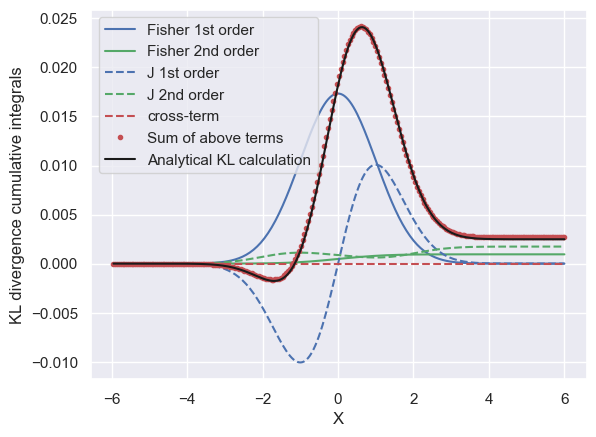

In [53]:
sn.set_theme()

xcint=xplot[1:]
plt.plot(xcint,fisher_first_cint,'-',color='b',label='Fisher 1st order')
plt.plot(xcint,fisher_second_cint,'-',color='g',label='Fisher 2nd order')
plt.plot(xcint,jterm_first_cint,'--',color='b',label='J 1st order')
plt.plot(xcint,jterm_second_cint,'--',color='g',label='J 2nd order')
plt.plot(xcint,cross_cint,'--',color='r',label='cross-term')

total_term_cint  = cumtrap(total_term,xplot)
# plt.plot(xcint,a_kl_cint,'-',color='k')
plt.plot(xcint,total_term_cint,'.',color = 'r',label='Sum of above terms')
plt.plot(xcint,a_kl_cint2,'-',color='k',label = 'Analytical KL calculation')
plt.xlabel('X')
plt.ylabel('KL divergence cumulative integrals')
# plt.grid()
plt.legend()


##### This is a cumulative integral, so the total KL divergence is the rightmost value. The Figure shows that the standard statistical Fisher second order term is not sufficient to explain the full KL divergence. The $\mathcal{J}$-term contribute to the KL divergence. These terms only exist because of a bias in the observed distribution. 

##### The nice fact is that these terms provide decoupled contributions, at least up to a second-order expansion. This knowledge can help detect and disentangle biases and possibly provide insight into how the brain attempts to reconstruct the underlying distribution.


### QED